In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_20.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_20.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        print(last_layer_hidden_states)
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


In [ ]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches:   1%|          | 1/154 [00:01<05:00,  1.96s/it]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.4544, -0.7518,  0.7968,  ..., -1.5931,  2.7541,  0.2477],
         [ 1.6828, -0.3641,  0.9254,  ..., -2.2190,  0.0698,  2.4341],
         ...,
         [-2.7112, -2.8376,  4.9214,  ...,  2.6805, -1.6844, -0.4845],
         [-2.6520, -2.9295,  4.9607,  ...,  2.4415, -1.5636, -0.5535],
         [-2.6168, -2.8111,  4.8505,  ...,  2.1117, -1.7806, -0.7373]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.3636,  2.4109, -1.7670,  ..., -1.5563, -1.4496, -0.7537],
         [-1.0479,  0.7238,  0.5648,  ..., -1.7530,  0.4150, -1.3433],
         ...,
         [-0.9678, -2.9629,  4.1960,  ...,  2.3175,  0.8177,  0.6873],
         [-1.7580, -3.8395,  3.5090,  ...,  2.3015,  0.4570,  0.5483],
         [-1.5693, -3.9972,  3.2478,  ...,  1.9996,  0.4781,  0.1850]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-1.6752,  1.2814, -1.4723,  ..., -2

Processing data batches:   1%|▏         | 2/154 [00:02<03:20,  1.32s/it]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.6517, -0.0147, -3.5942,  ..., -1.4690,  0.0892,  0.5953],
         [-0.4615, -0.1030, -2.3318,  ..., -0.1470,  0.5027,  0.4721],
         ...,
         [-1.9894, -3.6665,  3.1855,  ...,  1.3884, -1.0934, -0.4000],
         [-2.1500, -3.7796,  3.0399,  ...,  1.3674, -1.1629, -0.4398],
         [-2.0830, -3.9895,  3.0632,  ...,  1.3981, -1.2070, -0.4993]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.5415,  1.1193,  3.6409,  ..., -1.7610,  1.3158, -1.4478],
         [-0.5157, -0.3546, -3.3668,  ..., -1.9858,  1.2748,  1.2950],
         ...,
         [-3.0223, -4.5558,  1.9268,  ...,  1.4991, -0.7448,  0.0298],
         [-3.0461, -4.5980,  1.8558,  ...,  1.6158, -0.6253,  0.0748],
         [-2.9027, -4.7048,  1.8783,  ...,  1.6373, -0.5311,  0.0797]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.7788,  1.3048, -1.5320,  ..., -2

Processing data batches:   2%|▏         | 3/154 [00:03<02:41,  1.07s/it]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 2.5273, -1.1190, -2.9849,  ..., -2.9173,  1.7032, -2.9312],
         [ 1.1008,  1.2945,  0.9569,  ..., -2.8852,  0.2790,  0.5959],
         ...,
         [-0.7667,  0.0396, -6.0830,  ...,  2.4325,  0.1817,  3.2630],
         [-1.2614,  0.2638, -3.3298,  ..., -1.9893, -2.9896,  3.0063],
         [-1.1843, -0.6121,  0.9470,  ..., -0.8120,  1.1923,  1.3604]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 2.0406,  0.9539, -1.1578,  ..., -0.7365, -1.0531,  1.3598],
         [-1.1576,  0.2221, -3.5117,  ..., -1.1484,  2.5893, -0.6102],
         ...,
         [-2.3089, -2.7372,  3.6599,  ...,  1.4303, -0.3938, -0.7042],
         [-2.2795, -2.6944,  3.4905,  ...,  1.3021, -0.4446, -0.9158],
         [-2.1624, -2.8541,  3.5959,  ...,  1.3528, -0.4236, -1.1603]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.6779,  0.3424,  3.0026,  ..., -3

Processing data batches:   3%|▎         | 4/154 [00:04<02:25,  1.03it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 2.3510, -0.5647,  0.3894,  ..., -1.9709,  0.1020, -3.2869],
         [ 3.2396, -0.3460, -0.0605,  ..., -2.2986, -2.8123, -0.0796],
         ...,
         [-2.4974, -2.9888,  3.4327,  ...,  1.5100, -0.8537, -1.0477],
         [-2.3800, -3.0796,  3.5161,  ...,  1.5206, -0.8348, -1.1652],
         [-2.3159, -3.0479,  3.5413,  ...,  1.5228, -0.9369, -0.9838]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.4052, -1.3725, -0.6353,  ..., -1.0267,  0.8313,  0.4836],
         [ 4.1373, -1.0963, -1.4844,  ..., -2.5228, -0.0536,  1.8429],
         ...,
         [ 0.5390, -3.5004, -1.6726,  ..., -1.0355, -1.6831,  0.9572],
         [ 1.1200, -3.7611, -2.7903,  ...,  0.3101, -0.9579,  1.6488],
         [ 0.4488, -2.0324, -6.2606,  ...,  0.9120, -2.0318, -0.3251]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.9000, -1.1536,  1.8458,  ...,  0

Processing data batches:   3%|▎         | 5/154 [00:05<02:13,  1.11it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.9536, -2.3158,  2.6481,  ...,  0.6762,  0.0372, -0.5632],
         [ 1.3606,  1.1302, -0.4168,  ..., -0.7634, -0.0952,  0.8151],
         ...,
         [-2.3739, -0.5897,  1.2499,  ...,  4.2490,  3.8932,  0.2785],
         [-3.0487, -1.4990,  3.5556,  ..., -0.6925,  3.8111, -2.5682],
         [-0.5455,  0.2586, -0.0837,  ..., -3.6412,  2.0429,  0.5509]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.8434,  0.6121, -0.5767,  ..., -2.3286, -2.4902,  2.7805],
         [ 1.6271, -2.1736,  0.3687,  ...,  0.0446,  1.0588,  0.3501],
         ...,
         [-1.8867, -3.6580,  3.5603,  ...,  1.9235, -1.4149, -1.2407],
         [-1.7941, -3.6803,  3.3683,  ...,  1.7493, -1.4002, -1.1166],
         [-1.7609, -3.6621,  3.2895,  ...,  1.4077, -1.4203, -1.0806]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.3243,  0.5530,  1.0215,  ...,  0

Processing data batches:   4%|▍         | 6/154 [00:06<02:10,  1.13it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.8182, -1.8253, -0.9639,  ..., -1.3488, -0.2336,  0.9394],
         [-0.7852, -0.6723, -3.7445,  ..., -2.7497,  1.0589,  0.4177],
         ...,
         [ 1.2912,  1.0392, -0.4093,  ..., -0.7545, -2.0682, -1.4346],
         [ 2.7439,  1.5269,  0.8796,  ..., -1.0292,  1.5202,  0.4145],
         [ 4.7422,  0.5094,  0.5977,  ...,  0.4444,  0.4169, -0.9662]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-1.0524, -0.1989,  1.1864,  ..., -2.8604,  1.6640, -1.8920],
         [-0.4177, -1.6281, -0.7683,  ..., -1.7556,  0.8193,  0.5753],
         ...,
         [-2.4639, -3.6395,  3.1161,  ...,  2.3195, -1.3274, -1.2111],
         [-2.2400, -3.7055,  3.1412,  ...,  2.2244, -1.3062, -1.2206],
         [-2.0604, -3.7842,  3.1747,  ...,  2.1472, -1.1547, -1.2672]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 3.5858, -0.6849, -1.6776,  ..., -1

Processing data batches:   5%|▍         | 7/154 [00:06<02:06,  1.16it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-2.5471, -0.9346,  6.3672,  ..., -1.1859, -2.3737,  0.6226],
         [-2.0345, -2.9221,  1.2296,  ..., -0.7378,  1.4329, -0.3647],
         ...,
         [-3.0097, -3.3055,  3.4078,  ...,  1.7177, -0.9478, -0.7555],
         [-3.0757, -3.4235,  3.4648,  ...,  1.8313, -0.9155, -0.7918],
         [-2.8879, -3.4600,  3.4431,  ...,  1.8550, -0.8636, -0.7867]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-2.2035,  0.2090, -1.2629,  ..., -1.1805, -0.1396, -1.7871],
         [-1.3764, -2.3133,  2.4522,  ..., -0.4647,  0.6406,  2.0203],
         ...,
         [-2.2874, -2.5727,  3.6006,  ...,  1.6446, -1.2972, -0.4189],
         [-2.1901, -2.5806,  3.6371,  ...,  1.5883, -1.2757, -0.4593],
         [-2.0859, -2.6063,  3.4672,  ...,  1.5284, -1.2552, -0.4275]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.0981, -0.6092,  0.2346,  ..., -0

Processing data batches:   5%|▌         | 8/154 [00:07<02:01,  1.20it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 3.7848, -0.5363,  3.4263,  ..., -1.6109,  2.2391, -2.1438],
         [ 2.3406,  0.2928,  4.2895,  ...,  0.5509,  1.8011,  1.2607],
         ...,
         [-1.6148, -3.5636,  4.1030,  ...,  1.1668, -1.2877, -0.7540],
         [-1.5087, -3.5807,  4.0816,  ...,  1.3212, -1.2104, -0.8036],
         [-1.5909, -3.4642,  4.1243,  ...,  1.3919, -1.2031, -0.8746]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.0878,  0.1672, -0.1809,  ..., -2.5953, -0.4464,  1.2237],
         [ 0.0740, -1.2209, -1.5124,  ..., -1.5351,  0.4310,  0.9677],
         ...,
         [-1.3019, -2.6911,  2.2871,  ...,  1.1562, -1.8593, -0.5496],
         [-1.2749, -2.6708,  2.2463,  ...,  1.1893, -1.8444, -0.6285],
         [-1.2253, -2.7259,  2.2316,  ...,  1.2099, -1.7731, -0.6274]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.4583, -0.2503, -2.1698,  ...,  0

Processing data batches:   6%|▌         | 9/154 [00:08<01:59,  1.21it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.6068,  1.0462,  1.5089,  ..., -0.1405,  0.0520,  1.4993],
         [ 1.4254,  0.1220, -1.8417,  ..., -0.4285, -0.8934,  1.8034],
         ...,
         [-2.0754, -3.9634,  2.0332,  ...,  0.9910, -1.1193, -0.8873],
         [-1.9751, -3.9186,  2.0331,  ...,  1.0074, -1.2171, -0.8364],
         [-1.8406, -3.8046,  1.9996,  ...,  0.9838, -1.2641, -0.8545]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-1.0014, -1.0223, -1.1322,  ..., -2.9562, -0.4875, -0.3502],
         [-0.7166,  0.9581,  0.1822,  ..., -3.3556, -1.0361,  3.6333],
         ...,
         [-2.2543, -2.5006,  3.5323,  ...,  1.4654, -1.0838, -0.4733],
         [-2.2617, -2.5400,  3.4624,  ...,  1.4369, -1.1149, -0.5054],
         [-2.2414, -2.6256,  3.4993,  ...,  1.4035, -1.1141, -0.6161]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.5319,  2.3349,  1.9547,  ..., -2

Processing data batches:   6%|▋         | 10/154 [00:09<01:58,  1.22it/s]

tensor([[[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [ 5.9869e-01,  8.7073e-01, -6.3086e-01,  ..., -4.0622e+00,
           2.1668e+00,  1.2880e-01],
         [ 2.7019e-01, -2.0866e-01, -1.7481e+00,  ..., -2.9869e+00,
          -1.6601e-01, -6.1796e-01],
         ...,
         [-3.2141e+00, -6.6756e-01,  1.6154e+00,  ...,  1.1863e+00,
          -1.5860e+00,  1.2073e+00],
         [-2.6540e+00, -6.3857e-01,  1.6082e+00,  ...,  1.1103e+00,
          -1.5659e+00,  9.7001e-01],
         [-3.1924e+00, -2.1944e+00,  2.9255e+00,  ...,  1.8639e+00,
          -1.2627e+00,  3.9803e-03]],

        [[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [ 5.0552e-02,  5.2444e-01,  1.5964e-01,  ..., -3.3142e+00,
           3.3921e-01,  5.9569e-01],
         [ 9.4290e-01, -8.6769e-01, -3.7135e+00,  ..., -1.7066e+00,
          -1.3021e+00,  3.7425e-02],
         ...,
         [-1.3847e+00, -3

Processing data batches:   7%|▋         | 11/154 [00:10<01:55,  1.24it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.3895,  0.8405,  3.7474,  ...,  0.2539,  1.4786, -4.3590],
         [ 0.7863,  0.4855,  1.1254,  ..., -1.7064,  0.9171,  1.4723],
         ...,
         [-2.3162, -3.8902,  1.5021,  ...,  2.9523, -1.5971, -1.1313],
         [-2.2808, -3.9837,  1.4343,  ...,  2.9475, -1.5815, -1.0482],
         [-2.1491, -3.9688,  1.3826,  ...,  3.0213, -1.5485, -1.0352]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.9734, -3.3108, -1.8122,  ...,  3.9366,  0.9816, -0.6262],
         [ 2.7322, -0.7730, -0.8647,  ..., -0.1669,  2.3868,  0.6870],
         ...,
         [-1.4022,  1.0825,  3.3387,  ...,  1.2219, -1.5605,  1.4708],
         [-0.4456,  1.8604,  0.4325,  ...,  0.7700, -0.6541, -2.0863],
         [-2.8804, -0.0427,  0.6912,  ...,  0.4541,  1.1842,  0.2269]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-1.6496, -0.7980, -0.3785,  ..., -2

Processing data batches:   8%|▊         | 12/154 [00:10<01:56,  1.22it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.2678,  2.6765,  3.2553,  ..., -1.9931, -0.3432,  0.1184],
         [ 0.2202,  0.1930, -2.2055,  ..., -2.8738,  1.2668,  0.5679],
         ...,
         [ 0.0733,  1.1501,  3.4537,  ...,  4.7652, -2.0245,  1.9049],
         [ 0.5256,  0.0112, -1.3740,  ...,  4.0272, -1.6623,  3.9695],
         [ 2.6105,  0.3043,  4.1458,  ...,  6.6165,  1.2769,  1.8433]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 0.8189, -0.9021,  0.1382,  ..., -2.9696, -0.2037,  0.0659],
         [ 1.0636, -1.0837,  1.4734,  ..., -0.8149,  1.1355,  2.3273],
         ...,
         [-3.0559, -2.9465,  1.3814,  ...,  2.6568, -1.4081, -1.3061],
         [-3.1256, -2.8526,  1.1890,  ...,  2.7397, -1.2866, -1.1471],
         [-3.1605, -2.8059,  1.1738,  ...,  2.7595, -1.2682, -1.0414]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 2.3657, -0.2745,  1.5155,  ..., -2

Processing data batches:   8%|▊         | 13/154 [00:11<01:54,  1.23it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.2142, -0.3344,  1.3006,  ..., -2.4777,  0.8218,  0.6579],
         [-1.2656, -0.3200, -0.1698,  ..., -2.3918,  2.1301,  0.8258],
         ...,
         [-1.4229, -3.7454,  3.4317,  ...,  1.2932, -1.2163, -1.3176],
         [-1.2692, -3.6793,  3.0668,  ...,  1.4235, -1.3822, -1.1868],
         [-1.2403, -3.6789,  3.0461,  ...,  1.4926, -1.4253, -0.9587]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.6373, -0.1797,  0.5269,  ...,  0.3359,  1.2624,  1.7703],
         [-1.1990, -0.9957, -2.1865,  ..., -0.8736,  0.7790,  0.6020],
         ...,
         [-3.1488, -2.5478,  3.9358,  ...,  1.8863, -1.4593, -0.7245],
         [-3.1792, -2.5861,  3.9318,  ...,  1.9030, -1.4002, -0.6483],
         [-3.1743, -2.7628,  3.9755,  ...,  1.8525, -1.3005, -0.6304]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-3.0694,  2.1736, -3.3132,  ..., -3

Processing data batches:   9%|▉         | 14/154 [00:12<01:52,  1.24it/s]

tensor([[[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [-1.7212e+00,  4.1178e-01,  9.7282e-03,  ..., -1.3482e+00,
           1.5147e+00, -1.8818e+00],
         [-5.1780e-01,  3.6824e+00, -2.5809e+00,  ..., -2.8820e+00,
          -1.0183e+00,  8.4325e-01],
         ...,
         [ 3.0492e-01,  4.2379e+00, -4.3023e+00,  ...,  8.9737e-01,
           3.4814e+00,  4.8334e+00],
         [ 4.9524e-01,  2.3329e-01, -2.2526e+00,  ..., -2.3306e+00,
          -3.1874e-01,  7.3797e-01],
         [-2.1750e+00,  1.9217e+00, -1.9203e+00,  ...,  5.7610e-01,
          -1.3103e+00,  2.6201e+00]],

        [[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [-2.6418e-01, -1.1372e+00, -1.5603e+00,  ...,  1.6127e+00,
           2.2658e+00,  3.1534e-01],
         [ 7.1086e-01, -8.9596e-01,  2.2133e+00,  ..., -1.0344e+00,
           1.5021e+00,  1.6859e+00],
         ...,
         [-2.9961e+00, -2

Processing data batches:  10%|▉         | 15/154 [00:13<01:50,  1.25it/s]

tensor([[[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [-0.0794,  1.1577, -1.1076,  ...,  1.8497, -0.9866,  2.5620],
         [ 0.8951, -0.7907,  1.6704,  ..., -1.5644, -0.2728,  4.5371],
         ...,
         [-4.6790,  1.8788, -3.8985,  ...,  0.3233,  0.4381,  2.9761],
         [-0.9897, -3.9437,  4.6301,  ...,  1.5601, -1.1247, -0.5496],
         [-0.6568, -4.2847,  4.6503,  ...,  2.7559, -0.6625, -0.9928]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 1.2965,  0.9444,  1.3726,  ..., -2.1619,  2.5483,  0.6482],
         [ 1.0689, -0.1221, -1.5753,  ..., -3.6058,  2.2855, -0.6617],
         ...,
         [ 1.1006,  0.1658,  0.2118,  ...,  0.9178,  2.1778,  2.2803],
         [-3.0283,  0.8990, -4.5287,  ...,  1.3235,  2.4518, -0.8624],
         [-0.7006,  2.1896, -3.8331,  ...,  0.3708, -0.3280,  1.4857]],

        [[ 1.6576,  2.4239,  0.7786,  ..., -1.6885,  1.7764,  2.8429],
         [ 3.4808, -0.6726, -3.8038,  ..., -0

Processing data batches:  10%|█         | 16/154 [00:14<01:59,  1.15it/s]

tensor([[[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [-1.5477e+00,  6.3243e-01,  2.1938e-03,  ...,  9.0452e-01,
           2.2290e+00,  1.4642e+00],
         [ 2.9663e+00, -5.2193e-01, -1.7024e+00,  ..., -1.9949e+00,
           1.9005e+00,  1.2821e+00],
         ...,
         [-1.9774e+00, -3.8619e+00,  2.1866e+00,  ...,  8.2559e-01,
          -1.5293e+00, -1.4047e+00],
         [-1.9778e+00, -3.7550e+00,  2.2961e+00,  ...,  8.7035e-01,
          -1.4649e+00, -1.3898e+00],
         [-1.6902e+00, -3.8417e+00,  2.3511e+00,  ...,  9.4944e-01,
          -1.3337e+00, -1.3046e+00]],

        [[ 1.6576e+00,  2.4239e+00,  7.7857e-01,  ..., -1.6885e+00,
           1.7764e+00,  2.8429e+00],
         [-3.6975e-01,  1.5122e+00, -6.3714e-01,  ...,  5.4351e-03,
          -9.9800e-02,  1.5986e+00],
         [-8.5183e-01, -1.0529e+00,  4.4161e+00,  ..., -4.6488e-01,
          -1.5767e+00,  2.0929e+00],
         ...,
         [-7.8115e-02, -3

Processing data batches:  10%|█         | 16/154 [00:15<02:10,  1.06it/s]


KeyboardInterrupt: 

: 

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   1%|          | 19/2500 [00:00<00:59, 41.53it/s]

Epoch 10/2500, Loss: 3.5951
Test Accuracy at Epoch 10: 61.38%
Test F1-score at Epoch 10: 0.4444
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.57      0.92      0.70       123
non_infringement       0.79      0.31      0.44       123

        accuracy                           0.61       246
       macro avg       0.68      0.61      0.57       246
    weighted avg       0.68      0.61      0.57       246

New best model saved with F1-score 0.4444 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.57      0.92      0.70       123
non_infringement       0.79      0.31      0.44       123

        accuracy                           0.61       246
       macro avg       0.68      0.61      0.57       246
    weighted avg       0.68      0.61      0.57       246



Training Epochs:   1%|          | 25/2500 [00:00<01:08, 36.05it/s]

Epoch 20/2500, Loss: 0.3924
Test Accuracy at Epoch 20: 75.61%
Test F1-score at Epoch 20: 0.7391
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.82      0.77       123
non_infringement       0.79      0.69      0.74       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

New best model saved with F1-score 0.7391 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.82      0.77       123
non_infringement       0.79      0.69      0.74       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:   1%|▏         | 37/2500 [00:01<00:59, 41.11it/s]

Epoch 30/2500, Loss: 0.3935
Test Accuracy at Epoch 30: 76.42%
Test F1-score at Epoch 30: 0.7411
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.85      0.78       123
non_infringement       0.82      0.67      0.74       123

        accuracy                           0.76       246
       macro avg       0.77      0.76      0.76       246
    weighted avg       0.77      0.76      0.76       246

New best model saved with F1-score 0.7411 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.85      0.78       123
non_infringement       0.82      0.67      0.74       123

        accuracy                           0.76       246
       macro avg       0.77      0.76      0.76       246
    weighted avg       0.77      0.76      0.76       246



Training Epochs:   2%|▏         | 49/2500 [00:01<00:51, 47.88it/s]

Epoch 40/2500, Loss: 0.3416
Test Accuracy at Epoch 40: 79.67%
Test F1-score at Epoch 40: 0.8016
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       123
non_infringement       0.78      0.82      0.80       123

        accuracy                           0.80       246
       macro avg       0.80      0.80      0.80       246
    weighted avg       0.80      0.80      0.80       246

New best model saved with F1-score 0.8016 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       123
non_infringement       0.78      0.82      0.80       123

        accuracy                           0.80       246
       macro avg       0.80      0.80      0.80       246
    weighted avg       0.80      0.80      0.80       246

Epoch 50/2500, Loss: 0.2832
Test Accuracy at Epoch 50: 79.67%
Test F1-sco

Training Epochs:   3%|▎         | 68/2500 [00:01<00:48, 50.49it/s]

Epoch 60/2500, Loss: 0.2384
Test Accuracy at Epoch 60: 77.64%
Test F1-score at Epoch 60: 0.7699
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.76      0.80      0.78       123
non_infringement       0.79      0.75      0.77       123

        accuracy                           0.78       246
       macro avg       0.78      0.78      0.78       246
    weighted avg       0.78      0.78      0.78       246

Epoch 70/2500, Loss: 0.2069
Test Accuracy at Epoch 70: 75.20%
Test F1-score at Epoch 70: 0.7469
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.74      0.77      0.76       123
non_infringement       0.76      0.73      0.75       123

        accuracy                           0.75       246
       macro avg       0.75      0.75      0.75       246
    weighted avg       0.75      0.75      0.75       246



Training Epochs:   3%|▎         | 86/2500 [00:02<00:49, 48.60it/s]

Epoch 80/2500, Loss: 0.1831
Test Accuracy at Epoch 80: 74.80%
Test F1-score at Epoch 80: 0.7350
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.73      0.80      0.76       123
non_infringement       0.77      0.70      0.74       123

        accuracy                           0.75       246
       macro avg       0.75      0.75      0.75       246
    weighted avg       0.75      0.75      0.75       246

Epoch 90/2500, Loss: 0.1619
Test Accuracy at Epoch 90: 76.42%
Test F1-score at Epoch 90: 0.7478
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.73      0.83      0.78       123
non_infringement       0.80      0.70      0.75       123

        accuracy                           0.76       246
       macro avg       0.77      0.76      0.76       246
    weighted avg       0.77      0.76      0.76       246



Training Epochs:   4%|▍         | 110/2500 [00:02<00:45, 52.67it/s]

Epoch 100/2500, Loss: 0.1437
Test Accuracy at Epoch 100: 76.02%
Test F1-score at Epoch 100: 0.7401
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.73      0.84      0.78       123
non_infringement       0.81      0.68      0.74       123

        accuracy                           0.76       246
       macro avg       0.77      0.76      0.76       246
    weighted avg       0.77      0.76      0.76       246

Epoch 110/2500, Loss: 0.1284
Test Accuracy at Epoch 110: 76.02%
Test F1-score at Epoch 110: 0.7401
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.73      0.84      0.78       123
non_infringement       0.81      0.68      0.74       123

        accuracy                           0.76       246
       macro avg       0.77      0.76      0.76       246
    weighted avg       0.77      0.76      0.76       246



Training Epochs:   5%|▌         | 130/2500 [00:02<00:46, 51.32it/s]

Epoch 120/2500, Loss: 0.1151
Test Accuracy at Epoch 120: 73.58%
Test F1-score at Epoch 120: 0.7186
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.71      0.80      0.75       123
non_infringement       0.77      0.67      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.73       246
    weighted avg       0.74      0.74      0.73       246

Epoch 130/2500, Loss: 0.1032
Test Accuracy at Epoch 130: 73.58%
Test F1-score at Epoch 130: 0.7186
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.71      0.80      0.75       123
non_infringement       0.77      0.67      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.73       246
    weighted avg       0.74      0.74      0.73       246



Training Epochs:   6%|▌         | 150/2500 [00:03<00:46, 50.88it/s]

Epoch 140/2500, Loss: 0.1405
Test Accuracy at Epoch 140: 68.70%
Test F1-score at Epoch 140: 0.6169
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.64      0.87      0.74       123
non_infringement       0.79      0.50      0.62       123

        accuracy                           0.69       246
       macro avg       0.72      0.69      0.68       246
    weighted avg       0.72      0.69      0.68       246

Epoch 150/2500, Loss: 0.1525
Test Accuracy at Epoch 150: 63.82%
Test F1-score at Epoch 150: 0.5241
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.59      0.88      0.71       123
non_infringement       0.77      0.40      0.52       123

        accuracy                           0.64       246
       macro avg       0.68      0.64      0.62       246
    weighted avg       0.68      0.64      0.62       246



Training Epochs:   7%|▋         | 170/2500 [00:03<00:44, 52.34it/s]

Epoch 160/2500, Loss: 0.2380
Test Accuracy at Epoch 160: 77.24%
Test F1-score at Epoch 160: 0.7647
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.76      0.80      0.78       123
non_infringement       0.79      0.74      0.76       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246

Epoch 170/2500, Loss: 0.1404
Test Accuracy at Epoch 170: 71.14%
Test F1-score at Epoch 170: 0.6698
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.67      0.84      0.74       123
non_infringement       0.78      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.73      0.71      0.71       246
    weighted avg       0.73      0.71      0.71       246



Training Epochs:   7%|▋         | 183/2500 [00:03<00:45, 50.81it/s]

Epoch 180/2500, Loss: 0.1316
Test Accuracy at Epoch 180: 72.76%
Test F1-score at Epoch 180: 0.6968
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.69      0.83      0.75       123
non_infringement       0.79      0.63      0.70       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.72       246
    weighted avg       0.74      0.73      0.72       246



Training Epochs:   8%|▊         | 197/2500 [00:04<00:41, 55.83it/s]

Epoch 190/2500, Loss: 0.1063
Test Accuracy at Epoch 190: 73.98%
Test F1-score at Epoch 190: 0.7217
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.71      0.80      0.76       123
non_infringement       0.78      0.67      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 200/2500, Loss: 0.0968
Test Accuracy at Epoch 200: 73.17%
Test F1-score at Epoch 200: 0.7080
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.70      0.81      0.75       123
non_infringement       0.78      0.65      0.71       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.73       246
    weighted avg       0.74      0.73      0.73       246



Training Epochs:   9%|▊         | 217/2500 [00:04<00:40, 55.90it/s]

Epoch 210/2500, Loss: 0.0889
Test Accuracy at Epoch 210: 73.17%
Test F1-score at Epoch 210: 0.7105
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.66      0.71       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.73       246
    weighted avg       0.74      0.73      0.73       246

Epoch 220/2500, Loss: 0.0831
Test Accuracy at Epoch 220: 72.76%
Test F1-score at Epoch 220: 0.7048
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:   9%|▉         | 237/2500 [00:04<00:41, 54.88it/s]

Epoch 230/2500, Loss: 0.0781
Test Accuracy at Epoch 230: 72.76%
Test F1-score at Epoch 230: 0.7048
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 240/2500, Loss: 0.0741
Test Accuracy at Epoch 240: 72.76%
Test F1-score at Epoch 240: 0.7048
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  10%|█         | 261/2500 [00:05<00:41, 54.17it/s]

Epoch 250/2500, Loss: 0.0707
Test Accuracy at Epoch 250: 72.36%
Test F1-score at Epoch 250: 0.7018
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.74       123
non_infringement       0.76      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 260/2500, Loss: 0.0677
Test Accuracy at Epoch 260: 71.14%
Test F1-score at Epoch 260: 0.6926
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.69      0.77      0.73       123
non_infringement       0.74      0.65      0.69       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246



Training Epochs:  11%|█         | 280/2500 [00:05<00:41, 52.86it/s]

Epoch 270/2500, Loss: 0.0651
Test Accuracy at Epoch 270: 71.14%
Test F1-score at Epoch 270: 0.6926
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.69      0.77      0.73       123
non_infringement       0.74      0.65      0.69       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246

Epoch 280/2500, Loss: 0.0630
Test Accuracy at Epoch 280: 71.14%
Test F1-score at Epoch 280: 0.6926
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.77      0.73       123
non_infringement       0.74      0.65      0.69       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246



Training Epochs:  12%|█▏        | 299/2500 [00:06<00:40, 54.42it/s]

Epoch 290/2500, Loss: 0.0611
Test Accuracy at Epoch 290: 71.54%
Test F1-score at Epoch 290: 0.6983
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.69      0.77      0.73       123
non_infringement       0.74      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 300/2500, Loss: 0.0595
Test Accuracy at Epoch 300: 71.54%
Test F1-score at Epoch 300: 0.6983
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.69      0.77      0.73       123
non_infringement       0.74      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  13%|█▎        | 318/2500 [00:06<00:40, 54.52it/s]

Epoch 310/2500, Loss: 0.0582
Test Accuracy at Epoch 310: 72.36%
Test F1-score at Epoch 310: 0.7043
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 320/2500, Loss: 0.0570
Test Accuracy at Epoch 320: 72.36%
Test F1-score at Epoch 320: 0.7043
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  13%|█▎        | 337/2500 [00:06<00:40, 53.83it/s]

Epoch 330/2500, Loss: 0.0560
Test Accuracy at Epoch 330: 72.36%
Test F1-score at Epoch 330: 0.7043
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 340/2500, Loss: 0.0551
Test Accuracy at Epoch 340: 72.36%
Test F1-score at Epoch 340: 0.7043
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  14%|█▍        | 357/2500 [00:07<00:39, 53.83it/s]

Epoch 350/2500, Loss: 0.0544
Test Accuracy at Epoch 350: 72.36%
Test F1-score at Epoch 350: 0.7043
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 360/2500, Loss: 0.0537
Test Accuracy at Epoch 360: 72.36%
Test F1-score at Epoch 360: 0.7043
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  15%|█▌        | 381/2500 [00:07<00:40, 52.19it/s]

Epoch 370/2500, Loss: 0.0533
Test Accuracy at Epoch 370: 72.36%
Test F1-score at Epoch 370: 0.7043
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 380/2500, Loss: 0.0526
Test Accuracy at Epoch 380: 72.36%
Test F1-score at Epoch 380: 0.7043
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  16%|█▌        | 400/2500 [00:08<00:42, 49.36it/s]

Epoch 390/2500, Loss: 0.0522
Test Accuracy at Epoch 390: 72.76%
Test F1-score at Epoch 390: 0.7100
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 400/2500, Loss: 0.0517
Test Accuracy at Epoch 400: 72.76%
Test F1-score at Epoch 400: 0.7100
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  17%|█▋        | 420/2500 [00:08<00:41, 49.84it/s]

Epoch 410/2500, Loss: 0.0514
Test Accuracy at Epoch 410: 72.76%
Test F1-score at Epoch 410: 0.7100
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 420/2500, Loss: 0.0510
Test Accuracy at Epoch 420: 72.76%
Test F1-score at Epoch 420: 0.7100
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  18%|█▊        | 440/2500 [00:08<00:39, 51.66it/s]

Epoch 430/2500, Loss: 0.0507
Test Accuracy at Epoch 430: 72.76%
Test F1-score at Epoch 430: 0.7100
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 440/2500, Loss: 0.0504
Test Accuracy at Epoch 440: 72.76%
Test F1-score at Epoch 440: 0.7100
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  18%|█▊        | 460/2500 [00:09<00:39, 52.26it/s]

Epoch 450/2500, Loss: 0.0502
Test Accuracy at Epoch 450: 72.36%
Test F1-score at Epoch 450: 0.7069
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 460/2500, Loss: 0.0500
Test Accuracy at Epoch 460: 72.36%
Test F1-score at Epoch 460: 0.7069
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  19%|█▉        | 473/2500 [00:09<00:40, 49.44it/s]

Epoch 470/2500, Loss: 0.0497
Test Accuracy at Epoch 470: 72.36%
Test F1-score at Epoch 470: 0.7069
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  19%|█▉        | 487/2500 [00:09<00:35, 55.94it/s]

Epoch 480/2500, Loss: 0.0496
Test Accuracy at Epoch 480: 72.36%
Test F1-score at Epoch 480: 0.7069
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 490/2500, Loss: 0.0494
Test Accuracy at Epoch 490: 72.36%
Test F1-score at Epoch 490: 0.7069
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  20%|██        | 507/2500 [00:10<00:36, 55.28it/s]

Epoch 500/2500, Loss: 0.0492
Test Accuracy at Epoch 500: 72.36%
Test F1-score at Epoch 500: 0.7069
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 510/2500, Loss: 0.0491
Test Accuracy at Epoch 510: 72.36%
Test F1-score at Epoch 510: 0.7069
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  21%|██        | 527/2500 [00:10<00:35, 55.74it/s]

Epoch 520/2500, Loss: 0.0489
Test Accuracy at Epoch 520: 73.17%
Test F1-score at Epoch 520: 0.7179
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 530/2500, Loss: 0.0488
Test Accuracy at Epoch 530: 73.98%
Test F1-score at Epoch 530: 0.7288
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.72      0.78      0.75       123
non_infringement       0.76      0.70      0.73       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  22%|██▏       | 547/2500 [00:10<00:36, 54.25it/s]

Epoch 540/2500, Loss: 0.0487
Test Accuracy at Epoch 540: 73.98%
Test F1-score at Epoch 540: 0.7288
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.72      0.78      0.75       123
non_infringement       0.76      0.70      0.73       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 550/2500, Loss: 0.0486
Test Accuracy at Epoch 550: 73.17%
Test F1-score at Epoch 550: 0.7179
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  23%|██▎       | 571/2500 [00:11<00:36, 52.89it/s]

Epoch 560/2500, Loss: 0.0486
Test Accuracy at Epoch 560: 72.36%
Test F1-score at Epoch 560: 0.7069
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 570/2500, Loss: 0.0484
Test Accuracy at Epoch 570: 72.36%
Test F1-score at Epoch 570: 0.7069
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  24%|██▎       | 589/2500 [00:11<00:35, 53.81it/s]

Epoch 580/2500, Loss: 0.0483
Test Accuracy at Epoch 580: 71.54%
Test F1-score at Epoch 580: 0.6957
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 590/2500, Loss: 0.0482
Test Accuracy at Epoch 590: 71.14%
Test F1-score at Epoch 590: 0.6900
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  24%|██▍       | 608/2500 [00:12<00:34, 54.20it/s]

Epoch 600/2500, Loss: 0.0481
Test Accuracy at Epoch 600: 71.14%
Test F1-score at Epoch 600: 0.6900
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 610/2500, Loss: 0.0480
Test Accuracy at Epoch 610: 71.14%
Test F1-score at Epoch 610: 0.6900
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  25%|██▌       | 628/2500 [00:12<00:34, 55.00it/s]

Epoch 620/2500, Loss: 0.0480
Test Accuracy at Epoch 620: 71.14%
Test F1-score at Epoch 620: 0.6900
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 630/2500, Loss: 0.0479
Test Accuracy at Epoch 630: 71.14%
Test F1-score at Epoch 630: 0.6900
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  26%|██▌       | 647/2500 [00:12<00:35, 52.03it/s]

Epoch 640/2500, Loss: 0.0479
Test Accuracy at Epoch 640: 71.14%
Test F1-score at Epoch 640: 0.6900
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 650/2500, Loss: 0.0478
Test Accuracy at Epoch 650: 71.14%
Test F1-score at Epoch 650: 0.6900
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  27%|██▋       | 671/2500 [00:13<00:34, 52.58it/s]

Epoch 660/2500, Loss: 0.0478
Test Accuracy at Epoch 660: 71.14%
Test F1-score at Epoch 660: 0.6900
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 670/2500, Loss: 0.0477
Test Accuracy at Epoch 670: 71.14%
Test F1-score at Epoch 670: 0.6900
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  28%|██▊       | 690/2500 [00:13<00:34, 52.88it/s]

Epoch 680/2500, Loss: 0.0477
Test Accuracy at Epoch 680: 71.54%
Test F1-score at Epoch 680: 0.6957
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 690/2500, Loss: 0.0476
Test Accuracy at Epoch 690: 71.54%
Test F1-score at Epoch 690: 0.6957
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  28%|██▊       | 710/2500 [00:14<00:33, 54.09it/s]

Epoch 700/2500, Loss: 0.0476
Test Accuracy at Epoch 700: 71.54%
Test F1-score at Epoch 700: 0.6957
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 710/2500, Loss: 0.0475
Test Accuracy at Epoch 710: 71.54%
Test F1-score at Epoch 710: 0.6957
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  29%|██▉       | 730/2500 [00:14<00:33, 52.25it/s]

Epoch 720/2500, Loss: 0.0475
Test Accuracy at Epoch 720: 71.54%
Test F1-score at Epoch 720: 0.6957
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 730/2500, Loss: 0.0475
Test Accuracy at Epoch 730: 72.76%
Test F1-score at Epoch 730: 0.7124
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  30%|███       | 750/2500 [00:14<00:33, 51.82it/s]

Epoch 740/2500, Loss: 0.0476
Test Accuracy at Epoch 740: 71.54%
Test F1-score at Epoch 740: 0.6957
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 750/2500, Loss: 0.0475
Test Accuracy at Epoch 750: 72.76%
Test F1-score at Epoch 750: 0.7124
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  31%|███       | 770/2500 [00:15<00:33, 51.75it/s]

Epoch 760/2500, Loss: 0.0476
Test Accuracy at Epoch 760: 72.36%
Test F1-score at Epoch 760: 0.7069
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 770/2500, Loss: 0.0481
Test Accuracy at Epoch 770: 71.14%
Test F1-score at Epoch 770: 0.6900
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  32%|███▏      | 790/2500 [00:15<00:33, 51.18it/s]

Epoch 780/2500, Loss: 0.0490
Test Accuracy at Epoch 780: 72.76%
Test F1-score at Epoch 780: 0.7124
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 790/2500, Loss: 0.0477
Test Accuracy at Epoch 790: 72.76%
Test F1-score at Epoch 790: 0.7124
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  32%|███▏      | 803/2500 [00:15<00:34, 49.50it/s]

Epoch 800/2500, Loss: 0.0493
Test Accuracy at Epoch 800: 69.92%
Test F1-score at Epoch 800: 0.6696
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  33%|███▎      | 817/2500 [00:16<00:30, 55.92it/s]

Epoch 810/2500, Loss: 0.0502
Test Accuracy at Epoch 810: 72.76%
Test F1-score at Epoch 810: 0.7124
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 820/2500, Loss: 0.0491
Test Accuracy at Epoch 820: 73.17%
Test F1-score at Epoch 820: 0.7179
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  33%|███▎      | 837/2500 [00:16<00:30, 55.41it/s]

Epoch 830/2500, Loss: 0.0508
Test Accuracy at Epoch 830: 70.73%
Test F1-score at Epoch 830: 0.6814
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246

Epoch 840/2500, Loss: 0.0474
Test Accuracy at Epoch 840: 71.54%
Test F1-score at Epoch 840: 0.6930
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  34%|███▍      | 857/2500 [00:16<00:29, 54.99it/s]

Epoch 850/2500, Loss: 0.0507
Test Accuracy at Epoch 850: 73.17%
Test F1-score at Epoch 850: 0.7179
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 860/2500, Loss: 0.0484
Test Accuracy at Epoch 860: 72.76%
Test F1-score at Epoch 860: 0.7100
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  35%|███▌      | 877/2500 [00:17<00:29, 55.27it/s]

Epoch 870/2500, Loss: 0.0489
Test Accuracy at Epoch 870: 70.73%
Test F1-score at Epoch 870: 0.6814
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246

Epoch 880/2500, Loss: 0.0502
Test Accuracy at Epoch 880: 72.76%
Test F1-score at Epoch 880: 0.7124
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  36%|███▌      | 896/2500 [00:17<00:31, 51.55it/s]

Epoch 890/2500, Loss: 0.0474
Test Accuracy at Epoch 890: 72.76%
Test F1-score at Epoch 890: 0.7124
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 900/2500, Loss: 0.0504
Test Accuracy at Epoch 900: 70.73%
Test F1-score at Epoch 900: 0.6814
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246



Training Epochs:  37%|███▋      | 914/2500 [00:18<00:40, 38.97it/s]

Epoch 910/2500, Loss: 0.0481
Test Accuracy at Epoch 910: 72.76%
Test F1-score at Epoch 910: 0.7100
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  37%|███▋      | 927/2500 [00:18<00:32, 48.00it/s]

Epoch 920/2500, Loss: 0.0488
Test Accuracy at Epoch 920: 73.17%
Test F1-score at Epoch 920: 0.7179
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 930/2500, Loss: 0.0500
Test Accuracy at Epoch 930: 72.76%
Test F1-score at Epoch 930: 0.7100
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  38%|███▊      | 946/2500 [00:18<00:30, 50.98it/s]

Epoch 940/2500, Loss: 0.0474
Test Accuracy at Epoch 940: 71.54%
Test F1-score at Epoch 940: 0.6930
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 950/2500, Loss: 0.0503
Test Accuracy at Epoch 950: 73.17%
Test F1-score at Epoch 950: 0.7179
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  39%|███▉      | 970/2500 [00:19<00:30, 50.87it/s]

Epoch 960/2500, Loss: 0.0481
Test Accuracy at Epoch 960: 72.76%
Test F1-score at Epoch 960: 0.7100
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 970/2500, Loss: 0.0486
Test Accuracy at Epoch 970: 71.14%
Test F1-score at Epoch 970: 0.6872
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  40%|███▉      | 989/2500 [00:19<00:27, 53.97it/s]

Epoch 980/2500, Loss: 0.0500
Test Accuracy at Epoch 980: 72.76%
Test F1-score at Epoch 980: 0.7124
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.71      0.78      0.74       123
non_infringement       0.75      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 990/2500, Loss: 0.0473
Test Accuracy at Epoch 990: 73.17%
Test F1-score at Epoch 990: 0.7155
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  40%|████      | 1008/2500 [00:20<00:27, 53.37it/s]

Epoch 1000/2500, Loss: 0.0500
Test Accuracy at Epoch 1000: 71.14%
Test F1-score at Epoch 1000: 0.6872
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1010/2500, Loss: 0.0482
Test Accuracy at Epoch 1010: 72.76%
Test F1-score at Epoch 1010: 0.7100
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  41%|████      | 1027/2500 [00:20<00:28, 52.30it/s]

Epoch 1020/2500, Loss: 0.0481
Test Accuracy at Epoch 1020: 73.58%
Test F1-score at Epoch 1020: 0.7210
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1030/2500, Loss: 0.0501
Test Accuracy at Epoch 1030: 72.76%
Test F1-score at Epoch 1030: 0.7100
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  42%|████▏     | 1051/2500 [00:20<00:27, 52.16it/s]

Epoch 1040/2500, Loss: 0.0473
Test Accuracy at Epoch 1040: 72.76%
Test F1-score at Epoch 1040: 0.7100
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1050/2500, Loss: 0.0495
Test Accuracy at Epoch 1050: 73.58%
Test F1-score at Epoch 1050: 0.7210
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  43%|████▎     | 1063/2500 [00:21<00:36, 39.49it/s]

Epoch 1060/2500, Loss: 0.0490
Test Accuracy at Epoch 1060: 72.76%
Test F1-score at Epoch 1060: 0.7100
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  43%|████▎     | 1077/2500 [00:21<00:31, 45.36it/s]

Epoch 1070/2500, Loss: 0.0477
Test Accuracy at Epoch 1070: 71.14%
Test F1-score at Epoch 1070: 0.6872
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1080/2500, Loss: 0.0502
Test Accuracy at Epoch 1080: 73.58%
Test F1-score at Epoch 1080: 0.7210
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  44%|████▍     | 1101/2500 [00:22<00:29, 47.72it/s]

Epoch 1090/2500, Loss: 0.0474
Test Accuracy at Epoch 1090: 72.76%
Test F1-score at Epoch 1090: 0.7100
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1100/2500, Loss: 0.0488
Test Accuracy at Epoch 1100: 71.14%
Test F1-score at Epoch 1100: 0.6872
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  45%|████▍     | 1120/2500 [00:22<00:30, 45.53it/s]

Epoch 1110/2500, Loss: 0.0493
Test Accuracy at Epoch 1110: 73.17%
Test F1-score at Epoch 1110: 0.7155
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1120/2500, Loss: 0.0472
Test Accuracy at Epoch 1120: 73.17%
Test F1-score at Epoch 1120: 0.7155
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  46%|████▌     | 1138/2500 [00:22<00:26, 51.04it/s]

Epoch 1130/2500, Loss: 0.0499
Test Accuracy at Epoch 1130: 71.14%
Test F1-score at Epoch 1130: 0.6872
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.69       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1140/2500, Loss: 0.0478
Test Accuracy at Epoch 1140: 72.76%
Test F1-score at Epoch 1140: 0.7100
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  46%|████▋     | 1157/2500 [00:23<00:26, 51.24it/s]

Epoch 1150/2500, Loss: 0.0483
Test Accuracy at Epoch 1150: 73.58%
Test F1-score at Epoch 1150: 0.7210
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1160/2500, Loss: 0.0497
Test Accuracy at Epoch 1160: 72.76%
Test F1-score at Epoch 1160: 0.7100
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  47%|████▋     | 1181/2500 [00:23<00:25, 52.21it/s]

Epoch 1170/2500, Loss: 0.0471
Test Accuracy at Epoch 1170: 72.76%
Test F1-score at Epoch 1170: 0.7100
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1180/2500, Loss: 0.0492
Test Accuracy at Epoch 1180: 73.58%
Test F1-score at Epoch 1180: 0.7210
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  48%|████▊     | 1200/2500 [00:24<00:24, 52.71it/s]

Epoch 1190/2500, Loss: 0.0489
Test Accuracy at Epoch 1190: 72.76%
Test F1-score at Epoch 1190: 0.7100
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1200/2500, Loss: 0.0475
Test Accuracy at Epoch 1200: 72.36%
Test F1-score at Epoch 1200: 0.7043
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  49%|████▉     | 1220/2500 [00:24<00:24, 52.09it/s]

Epoch 1210/2500, Loss: 0.0499
Test Accuracy at Epoch 1210: 73.58%
Test F1-score at Epoch 1210: 0.7210
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1220/2500, Loss: 0.0473
Test Accuracy at Epoch 1220: 72.76%
Test F1-score at Epoch 1220: 0.7100
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  50%|████▉     | 1240/2500 [00:24<00:24, 51.15it/s]

Epoch 1230/2500, Loss: 0.0486
Test Accuracy at Epoch 1230: 72.36%
Test F1-score at Epoch 1230: 0.7043
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1240/2500, Loss: 0.0492
Test Accuracy at Epoch 1240: 73.17%
Test F1-score at Epoch 1240: 0.7155
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  50%|█████     | 1253/2500 [00:25<00:25, 49.62it/s]

Epoch 1250/2500, Loss: 0.0471
Test Accuracy at Epoch 1250: 72.76%
Test F1-score at Epoch 1250: 0.7100
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  51%|█████     | 1267/2500 [00:25<00:21, 56.24it/s]

Epoch 1260/2500, Loss: 0.0494
Test Accuracy at Epoch 1260: 71.54%
Test F1-score at Epoch 1260: 0.6930
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1270/2500, Loss: 0.0481
Test Accuracy at Epoch 1270: 72.76%
Test F1-score at Epoch 1270: 0.7100
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  51%|█████▏    | 1287/2500 [00:25<00:21, 56.36it/s]

Epoch 1280/2500, Loss: 0.0478
Test Accuracy at Epoch 1280: 73.58%
Test F1-score at Epoch 1280: 0.7210
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1290/2500, Loss: 0.0496
Test Accuracy at Epoch 1290: 72.36%
Test F1-score at Epoch 1290: 0.7043
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  52%|█████▏    | 1305/2500 [00:26<00:22, 52.79it/s]

Epoch 1300/2500, Loss: 0.0472
Test Accuracy at Epoch 1300: 72.76%
Test F1-score at Epoch 1300: 0.7100
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1310/2500, Loss: 0.0484
Test Accuracy at Epoch 1310: 73.58%
Test F1-score at Epoch 1310: 0.7210
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  53%|█████▎    | 1330/2500 [00:26<00:22, 53.07it/s]

Epoch 1320/2500, Loss: 0.0492
Test Accuracy at Epoch 1320: 72.76%
Test F1-score at Epoch 1320: 0.7100
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1330/2500, Loss: 0.0471
Test Accuracy at Epoch 1330: 72.36%
Test F1-score at Epoch 1330: 0.7043
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  54%|█████▍    | 1349/2500 [00:26<00:22, 52.00it/s]

Epoch 1340/2500, Loss: 0.0494
Test Accuracy at Epoch 1340: 73.58%
Test F1-score at Epoch 1340: 0.7210
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1350/2500, Loss: 0.0481
Test Accuracy at Epoch 1350: 72.76%
Test F1-score at Epoch 1350: 0.7100
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  55%|█████▍    | 1369/2500 [00:27<00:20, 55.17it/s]

Epoch 1360/2500, Loss: 0.0475
Test Accuracy at Epoch 1360: 72.36%
Test F1-score at Epoch 1360: 0.7043
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1370/2500, Loss: 0.0495
Test Accuracy at Epoch 1370: 73.58%
Test F1-score at Epoch 1370: 0.7210
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  56%|█████▌    | 1388/2500 [00:27<00:19, 55.62it/s]

Epoch 1380/2500, Loss: 0.0473
Test Accuracy at Epoch 1380: 72.76%
Test F1-score at Epoch 1380: 0.7100
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1390/2500, Loss: 0.0482
Test Accuracy at Epoch 1390: 72.36%
Test F1-score at Epoch 1390: 0.7043
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  56%|█████▋    | 1408/2500 [00:28<00:20, 54.42it/s]

Epoch 1400/2500, Loss: 0.0491
Test Accuracy at Epoch 1400: 73.17%
Test F1-score at Epoch 1400: 0.7155
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1410/2500, Loss: 0.0470
Test Accuracy at Epoch 1410: 72.76%
Test F1-score at Epoch 1410: 0.7100
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  57%|█████▋    | 1427/2500 [00:28<00:20, 52.98it/s]

Epoch 1420/2500, Loss: 0.0486
Test Accuracy at Epoch 1420: 71.54%
Test F1-score at Epoch 1420: 0.6930
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1430/2500, Loss: 0.0486
Test Accuracy at Epoch 1430: 73.17%
Test F1-score at Epoch 1430: 0.7155
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  58%|█████▊    | 1451/2500 [00:28<00:19, 54.86it/s]

Epoch 1440/2500, Loss: 0.0470
Test Accuracy at Epoch 1440: 72.76%
Test F1-score at Epoch 1440: 0.7100
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1450/2500, Loss: 0.0487
Test Accuracy at Epoch 1450: 71.54%
Test F1-score at Epoch 1450: 0.6930
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  59%|█████▉    | 1471/2500 [00:29<00:19, 54.06it/s]

Epoch 1460/2500, Loss: 0.0485
Test Accuracy at Epoch 1460: 73.17%
Test F1-score at Epoch 1460: 0.7155
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1470/2500, Loss: 0.0470
Test Accuracy at Epoch 1470: 72.76%
Test F1-score at Epoch 1470: 0.7100
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  59%|█████▉    | 1485/2500 [00:29<00:18, 53.83it/s]

Epoch 1480/2500, Loss: 0.0470
Test Accuracy at Epoch 1480: 72.76%
Test F1-score at Epoch 1480: 0.7100
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1490/2500, Loss: 0.0470
Test Accuracy at Epoch 1490: 72.76%
Test F1-score at Epoch 1490: 0.7100


Training Epochs:  60%|█████▉    | 1498/2500 [00:29<00:17, 58.19it/s]

Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1500/2500, Loss: 0.0474
Test Accuracy at Epoch 1500: 72.76%
Test F1-score at Epoch 1500: 0.7100
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  61%|██████    | 1519/2500 [00:30<00:16, 57.95it/s]

Epoch 1510/2500, Loss: 0.0481
Test Accuracy at Epoch 1510: 72.76%
Test F1-score at Epoch 1510: 0.7100
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1520/2500, Loss: 0.0471
Test Accuracy at Epoch 1520: 72.76%
Test F1-score at Epoch 1520: 0.7100
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  62%|██████▏   | 1539/2500 [00:30<00:16, 57.84it/s]

Epoch 1530/2500, Loss: 0.0471
Test Accuracy at Epoch 1530: 72.76%
Test F1-score at Epoch 1530: 0.7100
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1540/2500, Loss: 0.0470
Test Accuracy at Epoch 1540: 72.76%
Test F1-score at Epoch 1540: 0.7100
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  62%|██████▏   | 1559/2500 [00:30<00:16, 57.46it/s]

Epoch 1550/2500, Loss: 0.0474
Test Accuracy at Epoch 1550: 72.76%
Test F1-score at Epoch 1550: 0.7100
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1560/2500, Loss: 0.0480
Test Accuracy at Epoch 1560: 72.76%
Test F1-score at Epoch 1560: 0.7100
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  63%|██████▎   | 1580/2500 [00:31<00:16, 54.28it/s]

Epoch 1570/2500, Loss: 0.0471
Test Accuracy at Epoch 1570: 72.76%
Test F1-score at Epoch 1570: 0.7100
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1580/2500, Loss: 0.0473
Test Accuracy at Epoch 1580: 72.36%
Test F1-score at Epoch 1580: 0.7043
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  64%|██████▍   | 1602/2500 [00:31<00:16, 55.08it/s]

Epoch 1590/2500, Loss: 0.0471
Test Accuracy at Epoch 1590: 72.76%
Test F1-score at Epoch 1590: 0.7100
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1600/2500, Loss: 0.0470
Test Accuracy at Epoch 1600: 72.36%
Test F1-score at Epoch 1600: 0.7043
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  65%|██████▍   | 1616/2500 [00:31<00:16, 52.07it/s]

Epoch 1610/2500, Loss: 0.0473
Test Accuracy at Epoch 1610: 73.17%
Test F1-score at Epoch 1610: 0.7155
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  65%|██████▌   | 1630/2500 [00:32<00:15, 56.90it/s]

Epoch 1620/2500, Loss: 0.0476
Test Accuracy at Epoch 1620: 71.54%
Test F1-score at Epoch 1620: 0.6930
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1630/2500, Loss: 0.0474
Test Accuracy at Epoch 1630: 73.58%
Test F1-score at Epoch 1630: 0.7210
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  66%|██████▌   | 1649/2500 [00:32<00:14, 57.41it/s]

Epoch 1640/2500, Loss: 0.0473
Test Accuracy at Epoch 1640: 72.36%
Test F1-score at Epoch 1640: 0.7043
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1650/2500, Loss: 0.0475
Test Accuracy at Epoch 1650: 76.02%
Test F1-score at Epoch 1650: 0.7531
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  67%|██████▋   | 1668/2500 [00:32<00:14, 55.97it/s]

Epoch 1660/2500, Loss: 0.0475
Test Accuracy at Epoch 1660: 71.54%
Test F1-score at Epoch 1660: 0.6930
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1670/2500, Loss: 0.0474
Test Accuracy at Epoch 1670: 76.02%
Test F1-score at Epoch 1670: 0.7531
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  67%|██████▋   | 1687/2500 [00:33<00:14, 56.28it/s]

Epoch 1680/2500, Loss: 0.0474
Test Accuracy at Epoch 1680: 72.36%
Test F1-score at Epoch 1680: 0.7043
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1690/2500, Loss: 0.0475
Test Accuracy at Epoch 1690: 76.02%
Test F1-score at Epoch 1690: 0.7531
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  68%|██████▊   | 1711/2500 [00:33<00:14, 54.02it/s]

Epoch 1700/2500, Loss: 0.0474
Test Accuracy at Epoch 1700: 72.36%
Test F1-score at Epoch 1700: 0.7043
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1710/2500, Loss: 0.0473
Test Accuracy at Epoch 1710: 76.02%
Test F1-score at Epoch 1710: 0.7531
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  69%|██████▉   | 1730/2500 [00:34<00:14, 51.69it/s]

Epoch 1720/2500, Loss: 0.0474
Test Accuracy at Epoch 1720: 71.54%
Test F1-score at Epoch 1720: 0.6930
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.69      0.79      0.73       123
non_infringement       0.75      0.64      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1730/2500, Loss: 0.0473
Test Accuracy at Epoch 1730: 76.02%
Test F1-score at Epoch 1730: 0.7531
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  70%|███████   | 1750/2500 [00:34<00:14, 52.04it/s]

Epoch 1740/2500, Loss: 0.0473
Test Accuracy at Epoch 1740: 72.36%
Test F1-score at Epoch 1740: 0.7043
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1750/2500, Loss: 0.0473
Test Accuracy at Epoch 1750: 75.61%
Test F1-score at Epoch 1750: 0.7479
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  71%|███████   | 1763/2500 [00:34<00:14, 49.68it/s]

Epoch 1760/2500, Loss: 0.0472
Test Accuracy at Epoch 1760: 72.36%
Test F1-score at Epoch 1760: 0.7043
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  71%|███████   | 1777/2500 [00:34<00:12, 56.96it/s]

Epoch 1770/2500, Loss: 0.0472
Test Accuracy at Epoch 1770: 75.61%
Test F1-score at Epoch 1770: 0.7479
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1780/2500, Loss: 0.0472
Test Accuracy at Epoch 1780: 72.36%
Test F1-score at Epoch 1780: 0.7043
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  72%|███████▏  | 1797/2500 [00:35<00:12, 55.92it/s]

Epoch 1790/2500, Loss: 0.0471
Test Accuracy at Epoch 1790: 75.61%
Test F1-score at Epoch 1790: 0.7479
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1800/2500, Loss: 0.0471
Test Accuracy at Epoch 1800: 72.36%
Test F1-score at Epoch 1800: 0.7043
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  73%|███████▎  | 1818/2500 [00:35<00:11, 57.31it/s]

Epoch 1810/2500, Loss: 0.0471
Test Accuracy at Epoch 1810: 75.61%
Test F1-score at Epoch 1810: 0.7479
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1820/2500, Loss: 0.0470
Test Accuracy at Epoch 1820: 72.36%
Test F1-score at Epoch 1820: 0.7043
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  73%|███████▎  | 1837/2500 [00:36<00:11, 56.18it/s]

Epoch 1830/2500, Loss: 0.0470
Test Accuracy at Epoch 1830: 76.02%
Test F1-score at Epoch 1830: 0.7531
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1840/2500, Loss: 0.0470
Test Accuracy at Epoch 1840: 72.36%
Test F1-score at Epoch 1840: 0.7043
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  74%|███████▍  | 1858/2500 [00:36<00:11, 57.27it/s]

Epoch 1850/2500, Loss: 0.0470
Test Accuracy at Epoch 1850: 76.02%
Test F1-score at Epoch 1850: 0.7531
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1860/2500, Loss: 0.0470
Test Accuracy at Epoch 1860: 72.36%
Test F1-score at Epoch 1860: 0.7043
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  75%|███████▌  | 1877/2500 [00:36<00:11, 54.78it/s]

Epoch 1870/2500, Loss: 0.0470
Test Accuracy at Epoch 1870: 73.58%
Test F1-score at Epoch 1870: 0.7210
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1880/2500, Loss: 0.0469
Test Accuracy at Epoch 1880: 72.76%
Test F1-score at Epoch 1880: 0.7100
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  76%|███████▌  | 1896/2500 [00:37<00:11, 54.15it/s]

Epoch 1890/2500, Loss: 0.0469
Test Accuracy at Epoch 1890: 73.58%
Test F1-score at Epoch 1890: 0.7210
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  76%|███████▋  | 1909/2500 [00:37<00:10, 57.55it/s]

Epoch 1900/2500, Loss: 0.0469
Test Accuracy at Epoch 1900: 72.76%
Test F1-score at Epoch 1900: 0.7100
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1910/2500, Loss: 0.0470
Test Accuracy at Epoch 1910: 73.58%
Test F1-score at Epoch 1910: 0.7210
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  77%|███████▋  | 1928/2500 [00:37<00:10, 56.36it/s]

Epoch 1920/2500, Loss: 0.0470
Test Accuracy at Epoch 1920: 73.17%
Test F1-score at Epoch 1920: 0.7155
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1930/2500, Loss: 0.0470
Test Accuracy at Epoch 1930: 73.58%
Test F1-score at Epoch 1930: 0.7210
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246



Training Epochs:  78%|███████▊  | 1947/2500 [00:38<00:09, 55.31it/s]

Epoch 1940/2500, Loss: 0.0470
Test Accuracy at Epoch 1940: 73.17%
Test F1-score at Epoch 1940: 0.7155
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1950/2500, Loss: 0.0471
Test Accuracy at Epoch 1950: 73.17%
Test F1-score at Epoch 1950: 0.7155
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  79%|███████▉  | 1971/2500 [00:38<00:09, 54.54it/s]

Epoch 1960/2500, Loss: 0.0471
Test Accuracy at Epoch 1960: 73.58%
Test F1-score at Epoch 1960: 0.7210
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.68      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.74       246
    weighted avg       0.74      0.74      0.74       246

Epoch 1970/2500, Loss: 0.0472
Test Accuracy at Epoch 1970: 73.17%
Test F1-score at Epoch 1970: 0.7155
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  80%|███████▉  | 1990/2500 [00:38<00:09, 53.36it/s]

Epoch 1980/2500, Loss: 0.0473
Test Accuracy at Epoch 1980: 76.02%
Test F1-score at Epoch 1980: 0.7531
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 1990/2500, Loss: 0.0474
Test Accuracy at Epoch 1990: 72.76%
Test F1-score at Epoch 1990: 0.7100
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  80%|████████  | 2009/2500 [00:39<00:08, 54.87it/s]

Epoch 2000/2500, Loss: 0.0475
Test Accuracy at Epoch 2000: 76.02%
Test F1-score at Epoch 2000: 0.7531
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       123
non_infringement       0.78      0.73      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2010/2500, Loss: 0.0476
Test Accuracy at Epoch 2010: 72.76%
Test F1-score at Epoch 2010: 0.7100
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  81%|████████  | 2028/2500 [00:39<00:08, 54.05it/s]

Epoch 2020/2500, Loss: 0.0477
Test Accuracy at Epoch 2020: 76.83%
Test F1-score at Epoch 2020: 0.7635
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.76      0.79      0.77       123
non_infringement       0.78      0.75      0.76       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246

Epoch 2030/2500, Loss: 0.0478
Test Accuracy at Epoch 2030: 73.17%
Test F1-score at Epoch 2030: 0.7155
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  82%|████████▏ | 2047/2500 [00:40<00:08, 54.73it/s]

Epoch 2040/2500, Loss: 0.0479
Test Accuracy at Epoch 2040: 76.02%
Test F1-score at Epoch 2040: 0.7572
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2050/2500, Loss: 0.0480
Test Accuracy at Epoch 2050: 72.36%
Test F1-score at Epoch 2050: 0.7043
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  83%|████████▎ | 2067/2500 [00:40<00:07, 55.66it/s]

Epoch 2060/2500, Loss: 0.0481
Test Accuracy at Epoch 2060: 76.02%
Test F1-score at Epoch 2060: 0.7572
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2070/2500, Loss: 0.0483
Test Accuracy at Epoch 2070: 72.36%
Test F1-score at Epoch 2070: 0.7043
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  83%|████████▎ | 2086/2500 [00:40<00:08, 51.55it/s]

Epoch 2080/2500, Loss: 0.0483
Test Accuracy at Epoch 2080: 76.42%
Test F1-score at Epoch 2080: 0.7623
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  84%|████████▍ | 2099/2500 [00:40<00:07, 56.87it/s]

Epoch 2090/2500, Loss: 0.0484
Test Accuracy at Epoch 2090: 72.36%
Test F1-score at Epoch 2090: 0.7043
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2100/2500, Loss: 0.0484
Test Accuracy at Epoch 2100: 76.83%
Test F1-score at Epoch 2100: 0.7673
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  85%|████████▍ | 2118/2500 [00:41<00:06, 56.19it/s]

Epoch 2110/2500, Loss: 0.0485
Test Accuracy at Epoch 2110: 72.36%
Test F1-score at Epoch 2110: 0.7043
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2120/2500, Loss: 0.0485
Test Accuracy at Epoch 2120: 76.83%
Test F1-score at Epoch 2120: 0.7673
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  85%|████████▌ | 2137/2500 [00:41<00:06, 56.45it/s]

Epoch 2130/2500, Loss: 0.0485
Test Accuracy at Epoch 2130: 72.36%
Test F1-score at Epoch 2130: 0.7043
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2140/2500, Loss: 0.0484
Test Accuracy at Epoch 2140: 76.83%
Test F1-score at Epoch 2140: 0.7673
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  86%|████████▋ | 2161/2500 [00:42<00:06, 53.69it/s]

Epoch 2150/2500, Loss: 0.0485
Test Accuracy at Epoch 2150: 72.36%
Test F1-score at Epoch 2150: 0.7043
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2160/2500, Loss: 0.0483
Test Accuracy at Epoch 2160: 76.83%
Test F1-score at Epoch 2160: 0.7673
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  87%|████████▋ | 2180/2500 [00:42<00:05, 54.36it/s]

Epoch 2170/2500, Loss: 0.0483
Test Accuracy at Epoch 2170: 72.36%
Test F1-score at Epoch 2170: 0.7043
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2180/2500, Loss: 0.0482
Test Accuracy at Epoch 2180: 76.83%
Test F1-score at Epoch 2180: 0.7673
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  88%|████████▊ | 2200/2500 [00:42<00:05, 53.88it/s]

Epoch 2190/2500, Loss: 0.0481
Test Accuracy at Epoch 2190: 72.36%
Test F1-score at Epoch 2190: 0.7043
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2200/2500, Loss: 0.0480
Test Accuracy at Epoch 2200: 76.83%
Test F1-score at Epoch 2200: 0.7673
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  89%|████████▉ | 2222/2500 [00:43<00:04, 56.13it/s]

Epoch 2210/2500, Loss: 0.0479
Test Accuracy at Epoch 2210: 72.36%
Test F1-score at Epoch 2210: 0.7043
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 2220/2500, Loss: 0.0478
Test Accuracy at Epoch 2220: 76.83%
Test F1-score at Epoch 2220: 0.7673
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  89%|████████▉ | 2237/2500 [00:43<00:04, 52.73it/s]

Epoch 2230/2500, Loss: 0.0477
Test Accuracy at Epoch 2230: 72.36%
Test F1-score at Epoch 2230: 0.7043
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.66      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  90%|█████████ | 2250/2500 [00:43<00:04, 55.86it/s]

Epoch 2240/2500, Loss: 0.0475
Test Accuracy at Epoch 2240: 76.83%
Test F1-score at Epoch 2240: 0.7673
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       123
non_infringement       0.77      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246

Epoch 2250/2500, Loss: 0.0475
Test Accuracy at Epoch 2250: 72.76%
Test F1-score at Epoch 2250: 0.7100
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  91%|█████████ | 2269/2500 [00:44<00:04, 57.40it/s]

Epoch 2260/2500, Loss: 0.0473
Test Accuracy at Epoch 2260: 76.42%
Test F1-score at Epoch 2260: 0.7623
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2270/2500, Loss: 0.0473
Test Accuracy at Epoch 2270: 72.76%
Test F1-score at Epoch 2270: 0.7100
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.70      0.79      0.74       123
non_infringement       0.76      0.67      0.71       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  92%|█████████▏| 2289/2500 [00:44<00:03, 56.98it/s]

Epoch 2280/2500, Loss: 0.0472
Test Accuracy at Epoch 2280: 76.42%
Test F1-score at Epoch 2280: 0.7623
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2290/2500, Loss: 0.0471
Test Accuracy at Epoch 2290: 73.17%
Test F1-score at Epoch 2290: 0.7155
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.71      0.79      0.75       123
non_infringement       0.76      0.67      0.72       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  92%|█████████▏| 2308/2500 [00:44<00:03, 51.55it/s]

Epoch 2300/2500, Loss: 0.0470
Test Accuracy at Epoch 2300: 76.42%
Test F1-score at Epoch 2300: 0.7623
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2310/2500, Loss: 0.0470
Test Accuracy at Epoch 2310: 75.61%
Test F1-score at Epoch 2310: 0.7479
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  93%|█████████▎| 2327/2500 [00:45<00:03, 53.43it/s]

Epoch 2320/2500, Loss: 0.0469
Test Accuracy at Epoch 2320: 76.02%
Test F1-score at Epoch 2320: 0.7572
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2330/2500, Loss: 0.0469
Test Accuracy at Epoch 2330: 75.61%
Test F1-score at Epoch 2330: 0.7479
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  94%|█████████▍| 2345/2500 [00:45<00:03, 51.61it/s]

Epoch 2340/2500, Loss: 0.0469
Test Accuracy at Epoch 2340: 76.02%
Test F1-score at Epoch 2340: 0.7572
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2350/2500, Loss: 0.0469
Test Accuracy at Epoch 2350: 75.61%
Test F1-score at Epoch 2350: 0.7479
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  95%|█████████▍| 2371/2500 [00:46<00:02, 54.32it/s]

Epoch 2360/2500, Loss: 0.0469
Test Accuracy at Epoch 2360: 76.02%
Test F1-score at Epoch 2360: 0.7572
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2370/2500, Loss: 0.0469
Test Accuracy at Epoch 2370: 75.61%
Test F1-score at Epoch 2370: 0.7521
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.76      0.74      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  95%|█████████▌| 2385/2500 [00:46<00:02, 54.05it/s]

Epoch 2380/2500, Loss: 0.0470
Test Accuracy at Epoch 2380: 76.02%
Test F1-score at Epoch 2380: 0.7572
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2390/2500, Loss: 0.0470


Training Epochs:  96%|█████████▌| 2398/2500 [00:46<00:01, 58.30it/s]

Test Accuracy at Epoch 2390: 76.02%
Test F1-score at Epoch 2390: 0.7572
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2400/2500, Loss: 0.0471
Test Accuracy at Epoch 2400: 75.61%
Test F1-score at Epoch 2400: 0.7521
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.76      0.74      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  97%|█████████▋| 2418/2500 [00:46<00:01, 54.73it/s]

Epoch 2410/2500, Loss: 0.0472
Test Accuracy at Epoch 2410: 76.02%
Test F1-score at Epoch 2410: 0.7572
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2420/2500, Loss: 0.0473
Test Accuracy at Epoch 2420: 74.80%
Test F1-score at Epoch 2420: 0.7417
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.74      0.77      0.75       123
non_infringement       0.76      0.72      0.74       123

        accuracy                           0.75       246
       macro avg       0.75      0.75      0.75       246
    weighted avg       0.75      0.75      0.75       246



Training Epochs:  97%|█████████▋| 2436/2500 [00:47<00:01, 48.56it/s]

Epoch 2430/2500, Loss: 0.0474
Test Accuracy at Epoch 2430: 76.02%
Test F1-score at Epoch 2430: 0.7572
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       123
non_infringement       0.77      0.75      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  98%|█████████▊| 2442/2500 [00:47<00:01, 42.97it/s]

Epoch 2440/2500, Loss: 0.0475
Test Accuracy at Epoch 2440: 75.61%
Test F1-score at Epoch 2440: 0.7479
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  98%|█████████▊| 2455/2500 [00:47<00:00, 50.66it/s]

Epoch 2450/2500, Loss: 0.0476
Test Accuracy at Epoch 2450: 76.42%
Test F1-score at Epoch 2450: 0.7623
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2460/2500, Loss: 0.0477


Training Epochs:  99%|█████████▊| 2468/2500 [00:48<00:00, 46.34it/s]

Test Accuracy at Epoch 2460: 75.61%
Test F1-score at Epoch 2460: 0.7479
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  99%|█████████▉| 2474/2500 [00:48<00:00, 49.11it/s]

Epoch 2470/2500, Loss: 0.0478
Test Accuracy at Epoch 2470: 76.42%
Test F1-score at Epoch 2470: 0.7623
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  99%|█████████▉| 2487/2500 [00:48<00:00, 49.08it/s]

Epoch 2480/2500, Loss: 0.0479
Test Accuracy at Epoch 2480: 75.61%
Test F1-score at Epoch 2480: 0.7479
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 2490/2500, Loss: 0.0480
Test Accuracy at Epoch 2490: 76.42%
Test F1-score at Epoch 2490: 0.7623
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.76      0.77      0.77       123
non_infringement       0.77      0.76      0.76       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs: 100%|██████████| 2500/2500 [00:48<00:00, 51.28it/s]
/tmp/ipykernel_1341861/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0481
Test Accuracy at Epoch 2500: 75.61%
Test F1-score at Epoch 2500: 0.7479
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.74      0.79      0.76       123
non_infringement       0.77      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



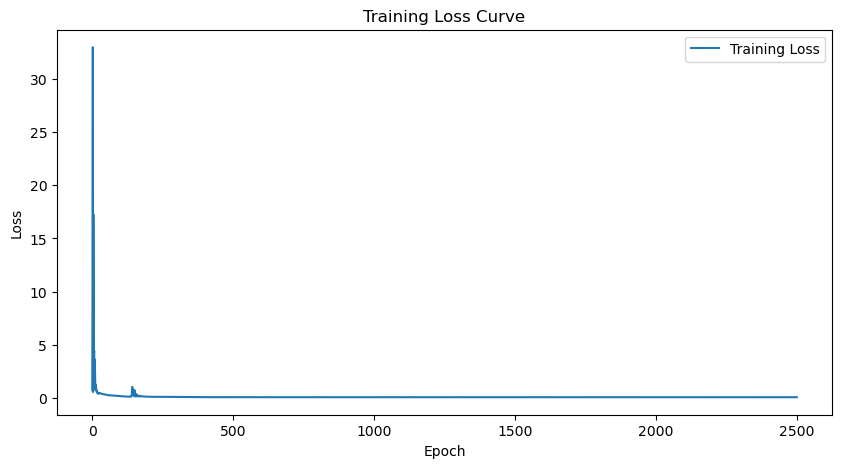

Final Model Accuracy: 79.67%
Final Model F1-score: 0.8016


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_1341861/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       123
non_infringement       0.78      0.82      0.80       123

        accuracy                           0.80       246
       macro avg       0.80      0.80      0.80       246
    weighted avg       0.80      0.80      0.80       246



: 